In [1]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.express as px

#from matplotlib import pyplot as plt
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

ModuleNotFoundError: No module named 'plotly'

In [4]:
# Wczytanie danych i podział (dane nie zawierają części dla walidatorów , została już pod tym kątem podzielona)
X_PRO = pd.read_csv('credit_PRO.csv')
credit,credit_test = train_test_split(
    X_PRO,
    stratify=X_PRO['TARGET'],
    test_size=0.3,
    random_state=42,
)

In [9]:
#ONE HOT ENCODING
pd.get_dummies(credit, columns=["REGION_RATING_CLIENT"],prefix=["RRC"]).head()
# np.where(credit["REGION_RATING_CLIENT"].str.contains("1"), 1, 0) 

AttributeError: Can only use .str accessor with string values!

Informacje o kolumnach 

In [4]:
credit.info()
# 'id': Identification number.
# 'TARGET': Binary variable indicating if the individual had difficulty in repaying the credit (1 for difficulty, 0 for no difficulty).
# 'CNT_CHILDREN': Number of children the individual has.    #JAKOSCOWA, 0,1,2,3,4,5,6+ GRUPY ROZWAŻYĆ
# 'AMT_INCOME_TOTAL': Total income of the individual.       #ANOMALIA
# 'AMT_CREDIT': Credit amount requested by the individual.      #ZKORELOWANE Z AMT_GOODS_PRICE
# 'AMT_ANNUITY': Annuity of the loan.               #LEKKO ZKORELOWANE Z AMT_CREDIT
# 'AMT_GOODS_PRICE': Price of the goods for which the loan is given.
# 'REGION_POPULATION_RELATIVE': Relative population of the region.      #? CO TO JEST, 80 unikalnych ,unikalne sumują się do 0,9994 
# 'DAYS_BIRTH': Age of the individual in days (negative value).    #CZY DOBRY FORMAT
# 'DAYS_EMPLOYED': Number of days the individual has been employed (negative value).    #CZY DOBRY FORMAT,BLEDY
# 'DAYS_REGISTRATION': Number of days the individual's registration was made relative to the current application.      #CZY DOBRY FORMAT
# 'DAYS_ID_PUBLISH': Number of days since the individual published their ID.        #CZY DOBRY FORMAT
# 'FLAG_WORK_PHONE': Binary flag indicating if the individual has a work phone (1 for yes, 0 for no).       #JAKOSCIOWA
# 'REGION_RATING_CLIENT': Region rating of the client.      # ? CO TO JEST, mowi o zamożności
# 'HOUR_APPR_PROCESS_START': Hour of the day when the loan application process started.


<class 'pandas.core.frame.DataFrame'>
Index: 9800 entries, 2039 to 11909
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          9800 non-null   int64  
 1   TARGET                      9800 non-null   int64  
 2   CNT_CHILDREN                9800 non-null   int64  
 3   AMT_INCOME_TOTAL            9800 non-null   float64
 4   AMT_CREDIT                  9800 non-null   float64
 5   AMT_ANNUITY                 9800 non-null   float64
 6   AMT_GOODS_PRICE             9793 non-null   float64
 7   REGION_POPULATION_RELATIVE  9800 non-null   float64
 8   DAYS_BIRTH                  9800 non-null   int64  
 9   DAYS_EMPLOYED               9800 non-null   int64  
 10  DAYS_REGISTRATION           9800 non-null   int64  
 11  DAYS_ID_PUBLISH             9800 non-null   int64  
 12  FLAG_WORK_PHONE             9800 non-null   int64  
 13  REGION_RATING_CLIENT        9800 n

Pogądowe wywołanie 'credit.describe()' i 'credit.head()' ,by zapoznać się z danymi z pierwszy rzut oka

In [5]:
credit.describe()

id       TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  \
count    9800.000000  9800.000000   9800.000000      9.800000e+03   
mean   132163.725510     0.178980      0.447143      1.796848e+05   
std     15620.469027     0.383355      0.757493      1.184200e+06   
min    100032.000000     0.000000      0.000000      2.565000e+04   
25%    119248.750000     0.000000      0.000000      1.125000e+05   
50%    138091.500000     0.000000      0.000000      1.440000e+05   
75%    145535.750000     0.000000      1.000000      2.025000e+05   
max    151427.000000     1.000000     11.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  9.800000e+03    9800.000000     9.793000e+03   
mean   5.972862e+05   27010.764643     5.351315e+05   
std    4.025437e+05   14805.240743     3.690719e+05   
min    4.500000e+04    2052.000000     4.500000e+04   
25%    2.700000e+05   16486.875000     2.385000e+05   
50%    5.151532e+05   24799.500000     4.500000e+05   
75%    8.086500e+05   34365.375000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE    DAYS_BIRTH  DAYS_EMPLOYED  \
count                 9800.000000   9800.000000    9800.000000   
mean                     0.020608 -15835.387041   59673.022551   
std                      0.013576   4339.056032  137663.843826   
min                      0.000533 -25166.000000  -17531.000000   
25%                      0.010006 -19350.000000   -2707.000000   
50%                      0.018850 -15463.000000   -1214.000000   
75%                      0.026960 -12259.750000    -319.000000   
max                      0.072508  -7683.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_WORK_PHONE  \
count        9800.000000      9800.000000      9800.000000   
mean        -4957.223265     -2973.994592         0.204082   
std          3485.606390      1514.058595         0.403049   
min        -21244.000000     -6223.000000         0.000000   
25%         -7417.000000     -4284.250000         0.000000   
50%         -4482.000000     -3209.000000         0.000000   
75%         -2001.750000     -1689.000000         0.000000   
max             0.000000        -3.000000         1.000000   

       REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  
count           9800.000000              9800.000000  
mean               2.066327                12.004898  
std                0.507409                 3.274242  
min                1.000000                 0.000000  
25%                2.000000                10.000000  
50%                2.000000                12.000000  
75%                2.000000                14.000000  
max                3.000000                22.000000

In [11]:
credit.head()

id  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
2039   136177       1             0          315000.0   1275772.5   
5563   149447       0             0          112500.0    164952.0   
13117  131924       1             0          157500.0   1258681.5   
7370   112361       1             1          180000.0   1067940.0   
11690  149036       0             0          202500.0   1440000.0   

       AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
2039       42291.0        1143000.0                    0.018801      -13890   
5563       10867.5         130500.0                    0.008866      -10739   
13117      40734.0         985500.0                    0.031329      -16815   
7370       34578.0         765000.0                    0.018634      -14234   
11690     133254.0        1440000.0                    0.005084      -21858   

       DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_WORK_PHONE  \
2039           -1168              -5356            -4061                0   
5563            -333              -1606            -2186                0   
13117          -5339              -3846             -174                0   
7370           -1101              -2997            -4716                0   
11690         365243             -12639            -4842                0   

       REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  
2039                      2                       13  
5563                      2                       12  
13117                     2                       15  
7370                      2                       18  
11690                     2                       14

In [29]:
credit['Rate'] = (((np.ceil(credit.AMT_CREDIT/credit.AMT_ANNUITY) * credit.AMT_ANNUITY) - credit.AMT_CREDIT)/credit.AMT_CREDIT)
((np.ceil(X.AMT_CREDIT/X.AMT_ANNUITY) * X.AMT_ANNUITY) - X.AMT_CREDIT)/X.AMT_CREDIT

# Na pierwszy rzut oka
-credit.sort_values('AMT_INCOME_TOTAL') - anomalia w zarobkach id 114967 MILIARDER \
-credit.loc[credit['DAYS_EMPLOYED']>0].shape - 1653 wierszy z błędną wartością DAYS_EMPOLYED \
-credit['REGION_POPULATION_RELATIVE'].unique().shape - 80 unikalnych wartości 'REGION_POPULATION_RELATIVE'\
-credit['REGION_POPULATION_RELATIVE'].unique().sum() - unikalne wartości sumują się do 0.9994540000000001, 


# Seria wykresów hist i density

0.1790%


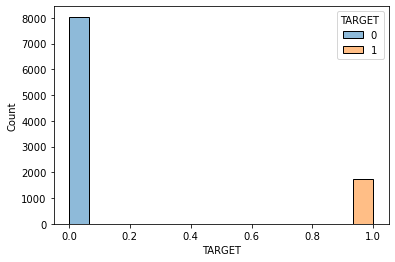

In [96]:
sns.histplot(data=credit,x='TARGET',hue='TARGET')
#Podzieł ze względu na zmienna TARGET nie jest nierównomierny
print(f'{credit.loc[credit.TARGET==1].shape[0]/credit.shape[0]:.4f}%')

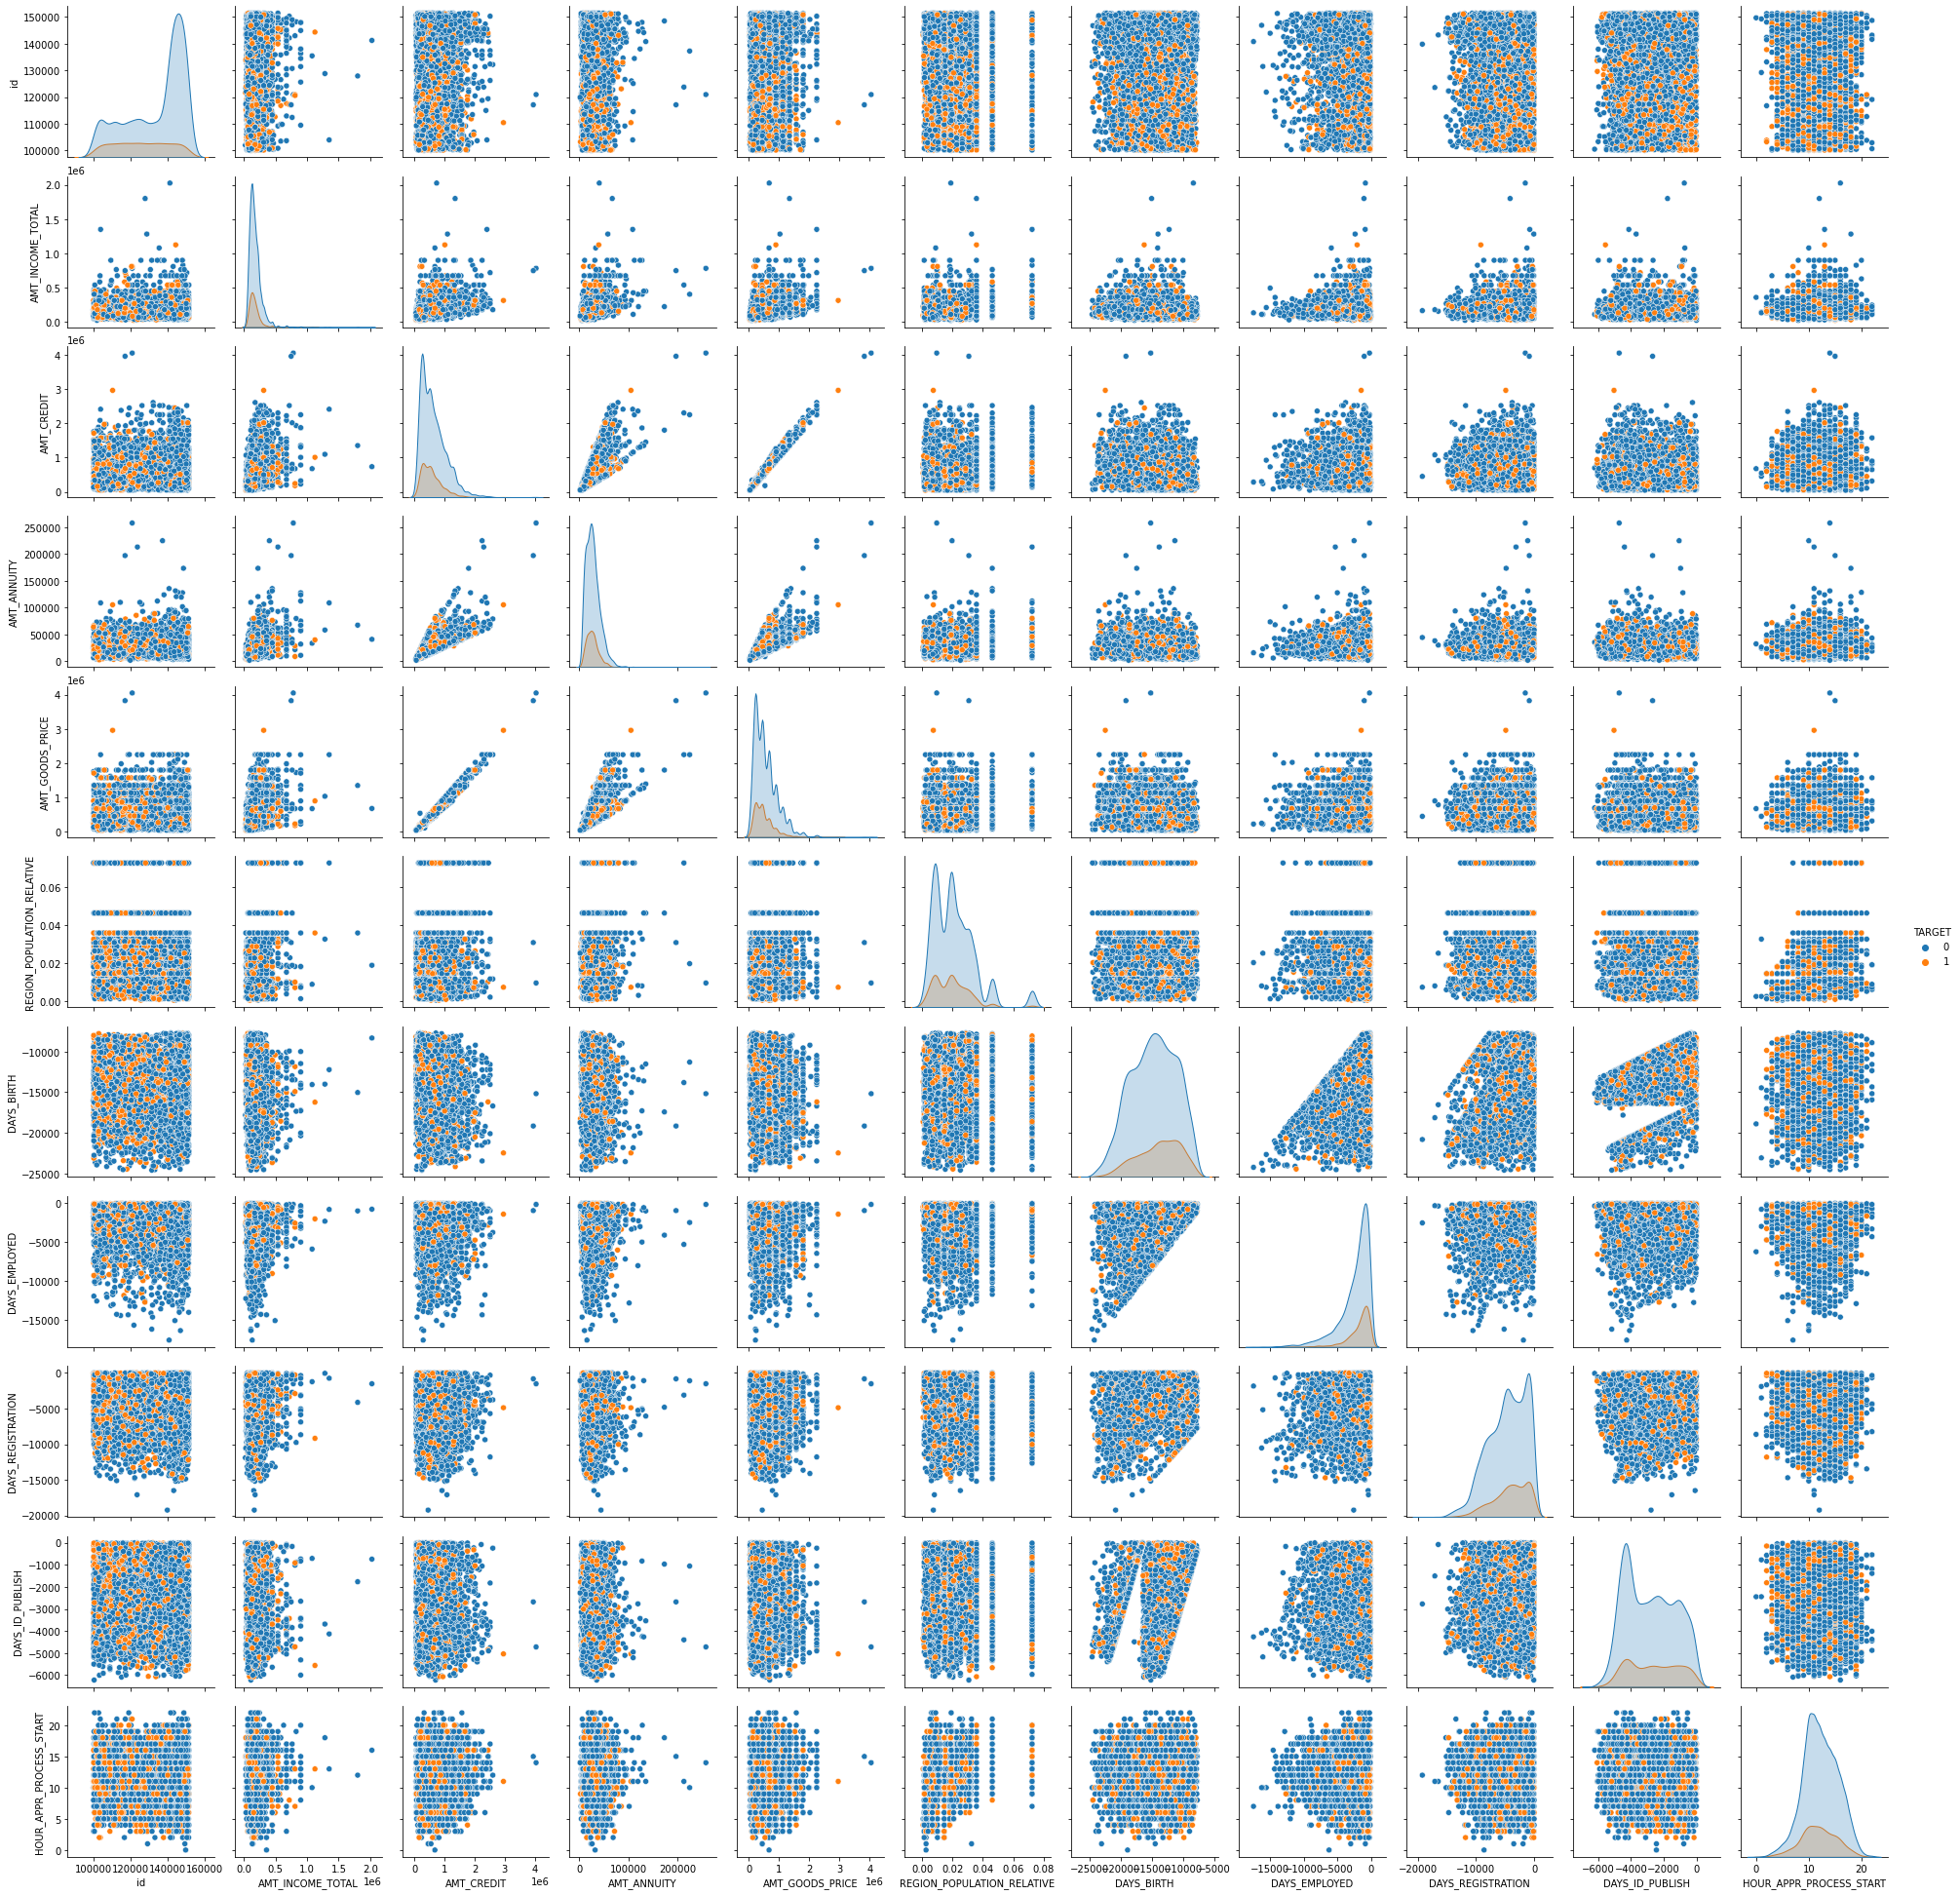

In [118]:
sns.pairplot(credit.loc[(credit["DAYS_EMPLOYED"]<=0) & (credit["AMT_INCOME_TOTAL"] < 10**8)][['id', 'TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START']],hue='TARGET')

 Szukaliśmy zalezności miedzy REGION_RATING_CLIENT,FLAG_WORK_PHONE,REGION_POPULATION_RELATIVE ,a 'zamożnością' ,
 (wierzyliśmy ,że to powinno się wiązać z TARGETEM)


In [69]:
people_df = credit[['REGION_RATING_CLIENT','TARGET','FLAG_WORK_PHONE']].value_counts().reset_index(name="suma").sort_values(['REGION_RATING_CLIENT','TARGET','FLAG_WORK_PHONE'])
#sns.scatterplot(data = credit.loc[(credit.id!=114967)],x = 'REGION_POPULATION_RELATIVE',y = 'REGION_RATING_CLIENT',hue='TARGET')
people_df

REGION_RATING_CLIENT  TARGET  FLAG_WORK_PHONE  suma
4                      1       0                0   696
8                      1       0                1   158
9                      1       1                0    85
11                     1       1                1    19
0                      2       0                0  4731
1                      2       0                1  1224
2                      2       1                0  1001
6                      2       1                1   278
3                      3       0                0  1001
7                      3       0                1   236
5                      3       1                0   286
10                     3       1                1    85

In [70]:
# Procent ludzi z regionów , którzy nie spłacili
df_1 = people_df.groupby(['REGION_RATING_CLIENT','TARGET']).agg(a = ('suma','sum')).reset_index()
a =df_1.loc[df_1["TARGET"]==1].reset_index()["a"]
b = df_1.groupby('REGION_RATING_CLIENT').agg(a = ('a','sum')).reset_index()["a"]
a/b

0    0.108559
1    0.176804
2    0.230721
Name: a, dtype: float64

In [75]:
# szukamy zależność posiadania telefonu roboczego ,a REGION_RATING_CLIENT
df_1 = people_df.groupby(['REGION_RATING_CLIENT','FLAG_WORK_PHONE']).agg(a = ('suma','sum')).reset_index()
df_1

REGION_RATING_CLIENT  FLAG_WORK_PHONE     a
0                     1                0   781
1                     1                1   177
2                     2                0  5732
3                     2                1  1502
4                     3                0  1287
5                     3                1   321

0.035792    750
0.025164    587
0.046220    565
0.030755    537
0.026392    537
           ... 
0.003541     26
0.001417     20
0.001333     11
0.000938      4
0.000533      4
Name: REGION_POPULATION_RELATIVE, Length: 80, dtype: int64

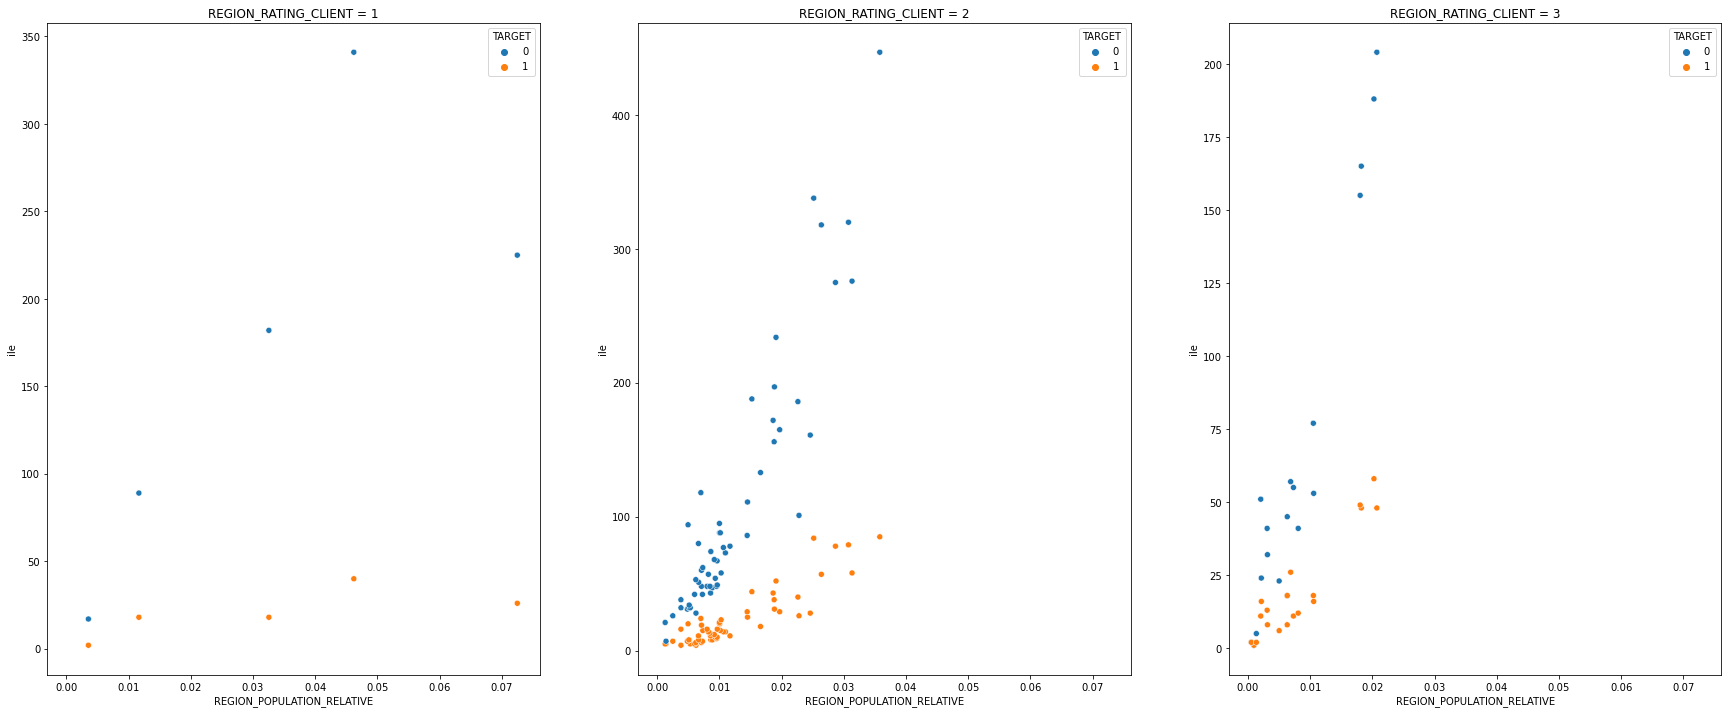

In [32]:
ok = data=credit[['REGION_POPULATION_RELATIVE','REGION_RATING_CLIENT','TARGET']].groupby(['REGION_POPULATION_RELATIVE','REGION_RATING_CLIENT','TARGET']).value_counts().reset_index(name="ile").sort_values('ile')
figure,axs = plt.subplots(1,3,figsize = (30,12),sharex = True)
axs = axs.flatten()
fig1 = sns.scatterplot(data = ok.loc[ok['REGION_RATING_CLIENT']==1],
                x='REGION_POPULATION_RELATIVE',y='ile',hue='TARGET',ax = axs[0])
axs[0].set_title("REGION_RATING_CLIENT = 1")
fig2 = sns.scatterplot(data = ok.loc[ok['REGION_RATING_CLIENT']==2],
                x='REGION_POPULATION_RELATIVE',y='ile',hue='TARGET',ax = axs[1])
axs[1].set_title("REGION_RATING_CLIENT = 2")
fog3 = sns.scatterplot(data = ok.loc[ok['REGION_RATING_CLIENT']==3],
                x='REGION_POPULATION_RELATIVE',y='ile',hue='TARGET',ax = axs[2])
axs[2].set_title("REGION_RATING_CLIENT = 3")

X_PRO.REGION_POPULATION_RELATIVE.value_counts()
# Stosunek ludzi z problemami do ludzi bez problemów jest najmniejszy dla REGION_RATING_CLIENT = 1, średni dla REGION_RATING_CLIENT = 2,
# i najwiekszy dla REGION_RATING_CLIENT = 3

In [ ]:
#Stosunek ludzi mających TARGET==1 do tych mających target==0 jest różny w zależności od REGION_RATING_CLIENT co obrazuję zbiory punktów,
# podopasowaniu prostuch do zbiorow niebieskich i pomaranczowych (czego nie zrobiliśmy bo uznalismy ze jest to juz dobrze widoczne) widac ze kąt nachylenia
# jednej prostej do drugiej jest zdecydowanie ostrzejszy dla wyższych dla wiekszych REGION_RATING_CLIENT 

<AxesSubplot:xlabel='REGION_RATING_CLIENT', ylabel='REGION_POPULATION_RELATIVE'>

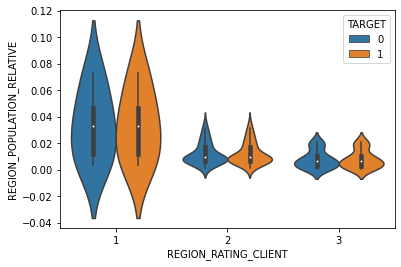

In [76]:
sns.violinplot(data = ok,
                y='REGION_POPULATION_RELATIVE',x='REGION_RATING_CLIENT',hue='TARGET')

# Density wykresy

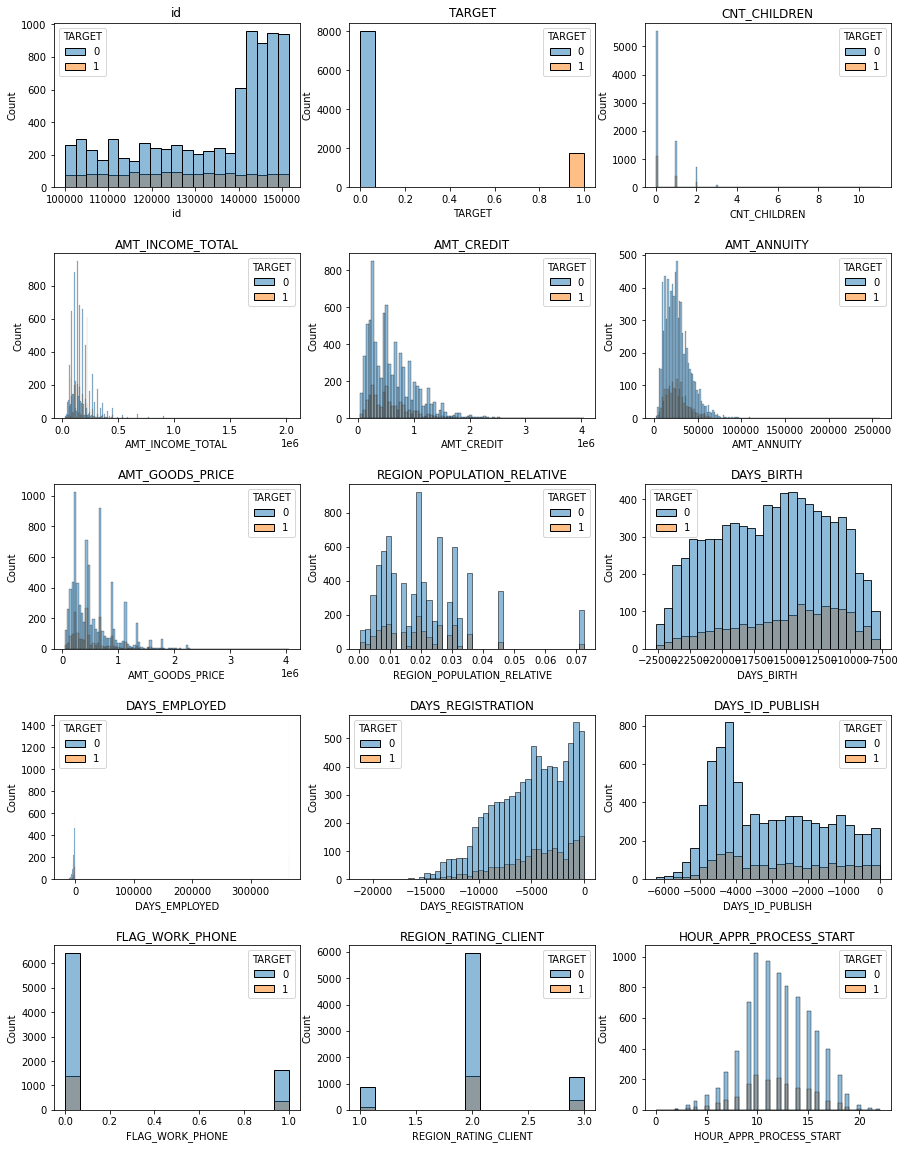

In [15]:
figure,axs = plt.subplots(5,3,figsize = (15,20))
figure.subplots_adjust(hspace = 0.4)
axs = axs.flatten()
for i,col in enumerate(credit.columns):
    sns.histplot(data=credit.loc[credit.id!=114967],
                        x=col,
                        hue = 'TARGET',
                        ax=axs[i])
    axs[i].set_title(col)
    


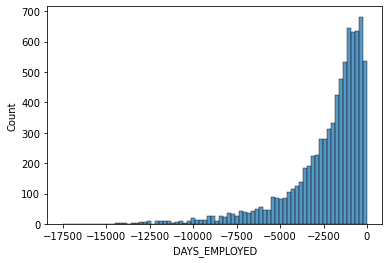

In [13]:
sns.histplot(data=credit.loc[credit.DAYS_EMPLOYED<0],x = 'DAYS_EMPLOYED')
credit_tempo = credit.copy()
credit_tempo.loc[credit_tempo.DAYS_EMPLOYED > 0,'DAYS_EMPLOYED'] = credit.loc[credit.DAYS_EMPLOYED<0].DAYS_EMPLOYED.mean()


<AxesSubplot:xlabel='AMT_CREDIT', ylabel='Count'>

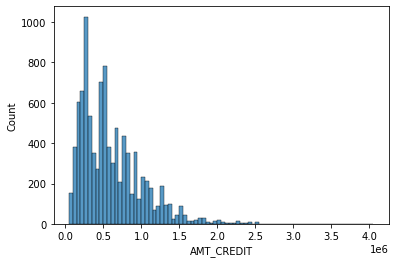

In [37]:
sns.histplot(data=credit,x = 'AMT_CREDIT')


# Macierz do wykresu heatmap

In [20]:
#pd.cut(credit_num["AMT_INCOME_TOTAL"],20,labels=np.arange(1,21)).reset_index(name="category")
#credit_num = credit_num.loc[(credit_num["DAYS_EMPLOYED"]<=0) & (credit_num["AMT_INCOME_TOTAL"] < 10**8)]
credit_num = credit[["TARGET",'AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']]
credit_cat = credit[['TARGET','CNT_CHILDREN','REGION_POPULATION_RELATIVE','FLAG_WORK_PHONE','REGION_RATING_CLIENT','HOUR_APPR_PROCESS_START']]
credit_heat = credit_num.loc[(credit_num["DAYS_EMPLOYED"]<=0) & (credit_num["AMT_INCOME_TOTAL"] < 10**8)]
for i in credit_heat.columns[1:]:
     credit_heat[i] =  pd.cut(credit_heat[i],30,labels=np.arange(1,31))

credit_heat_T = credit_heat.loc[credit_heat["TARGET"]==1].astype(int)
credit_heat_NT = credit_heat.loc[credit_heat["TARGET"]==0].astype(int)

C:\Users\endoa\AppData\Local\Temp\ipykernel_11792\3847857633.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_heat[i] =  pd.cut(credit_heat[i],30,labels=np.arange(1,31))
C:\Users\endoa\AppData\Local\Temp\ipykernel_11792\3847857633.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_heat[i] =  pd.cut(credit_heat[i],30,labels=np.arange(1,31))
C:\Users\endoa\AppData\Local\Temp\ipykernel_11792\3847857633.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

<AxesSubplot:>

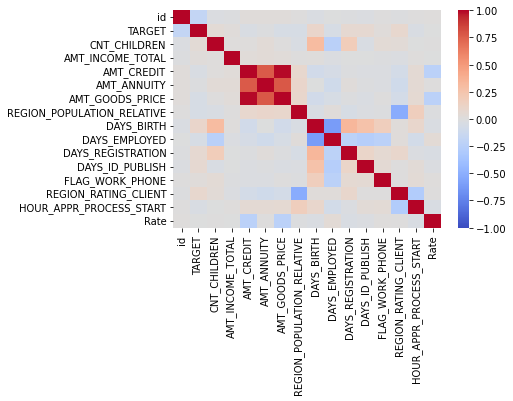

In [30]:
sns.heatmap(credit.corr(),vmin=-1,vmax=1,cmap='coolwarm')

C:\Users\endoa\AppData\Local\Temp\ipykernel_15168\1383258266.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


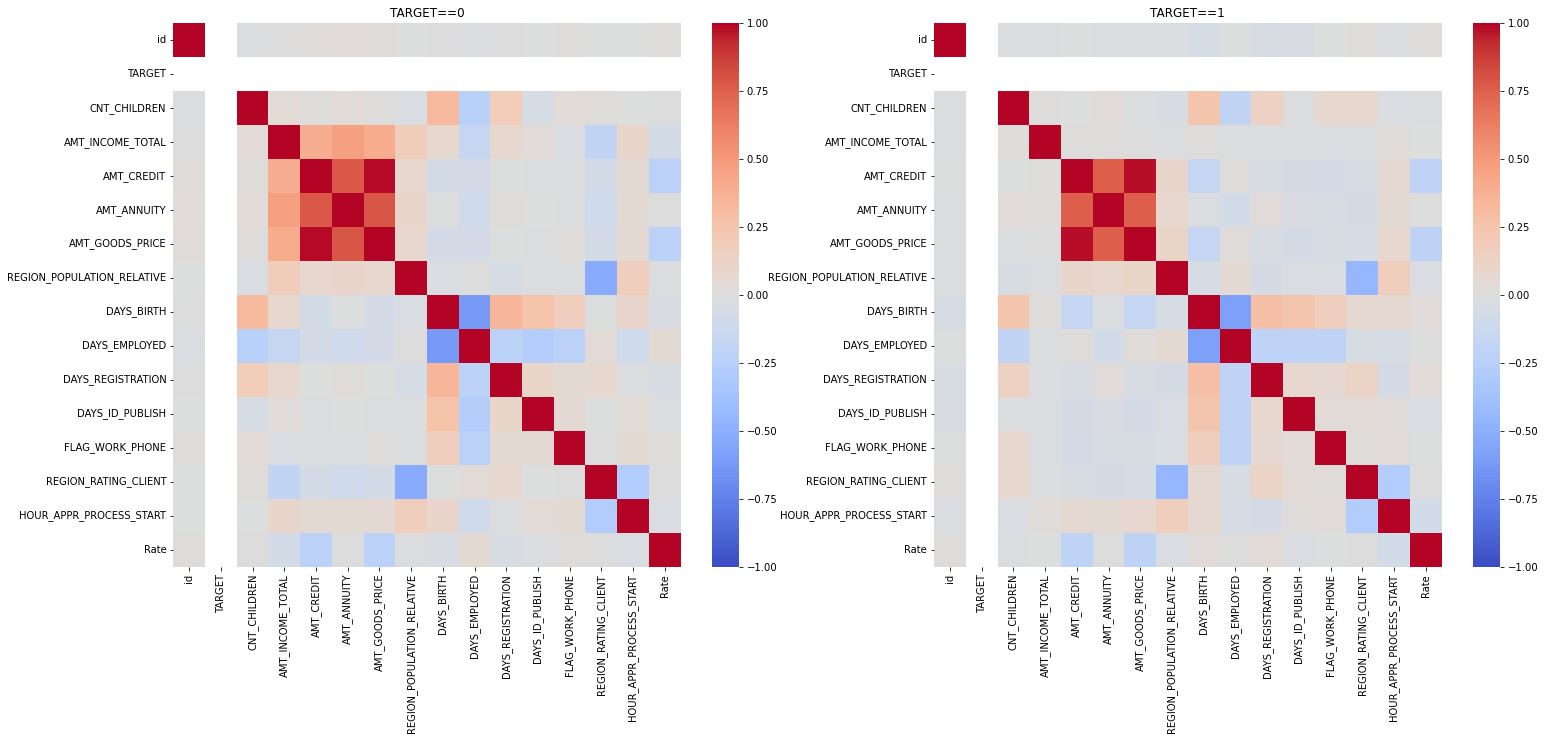

In [31]:
figure, axes = plt.subplots(1, 2, sharex=True,
                            figsize=(25, 10))
sns.heatmap(credit.loc[credit.TARGET==0].corr(),
          ax=axes[0],cmap='coolwarm',vmin=-1,vmax=1)
axes[0].set_title("TARGET==0")
sns.heatmap(credit.loc[credit.TARGET==1].corr(),
            ax=axes[1],cmap='coolwarm',vmin=-1,vmax=1)
axes[1].set_title("TARGET==1")
figure.show()

# Wykresy dwuwymiarowej gęstości zmiennych numerycznych

C:\Users\endoa\AppData\Local\Temp\ipykernel_11792\452298618.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure, axes = plt.subplots(1, 2, sharex=True,


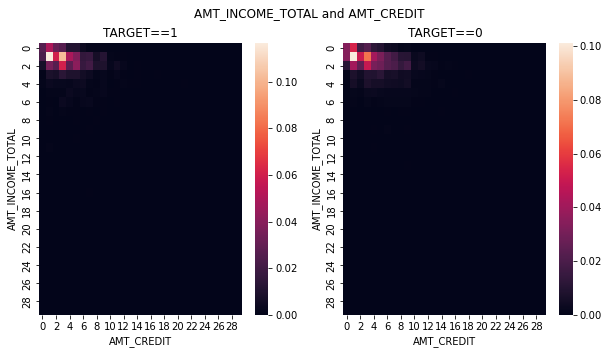

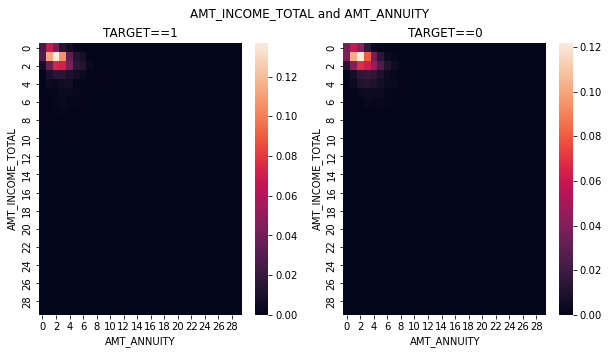

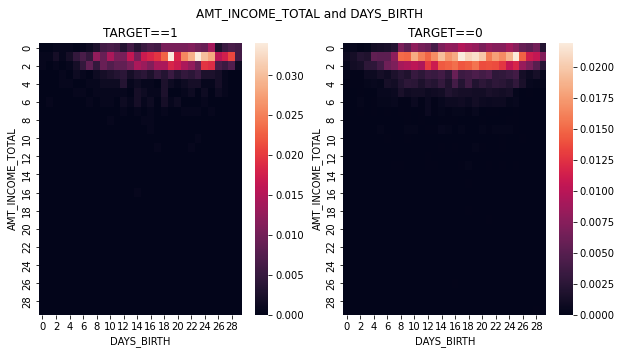

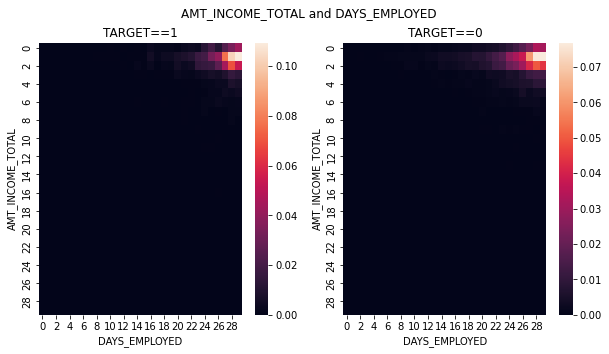

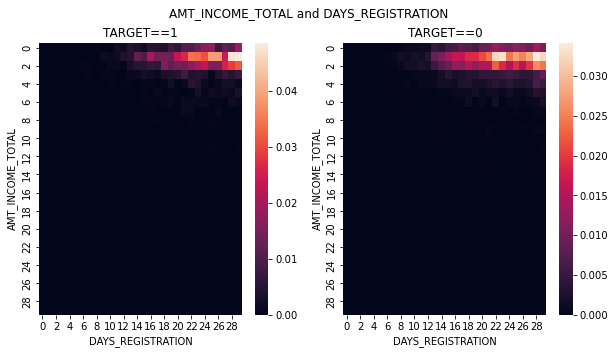

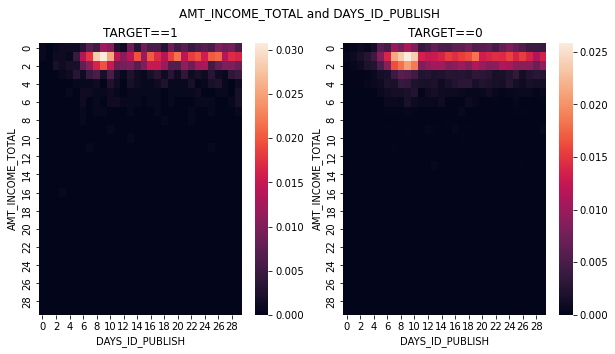

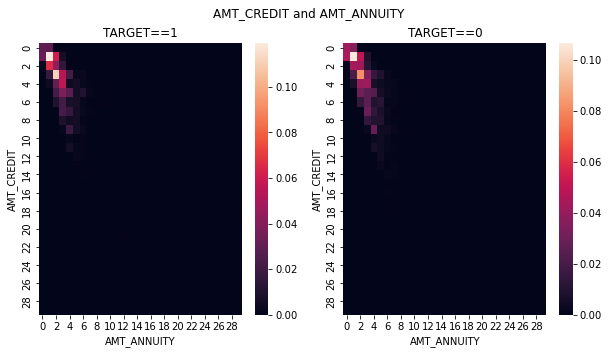

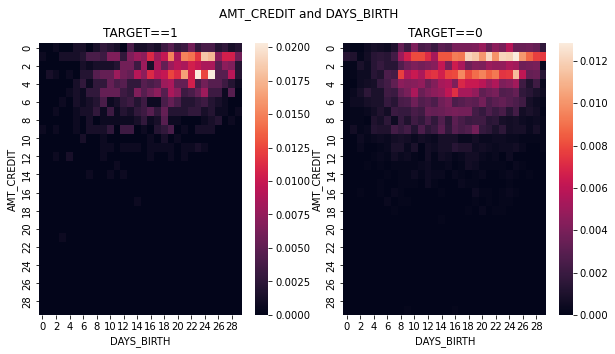

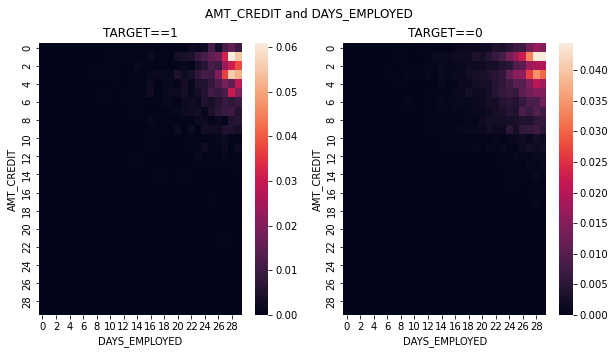

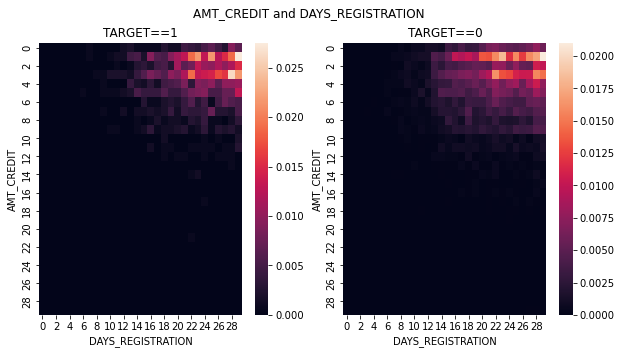

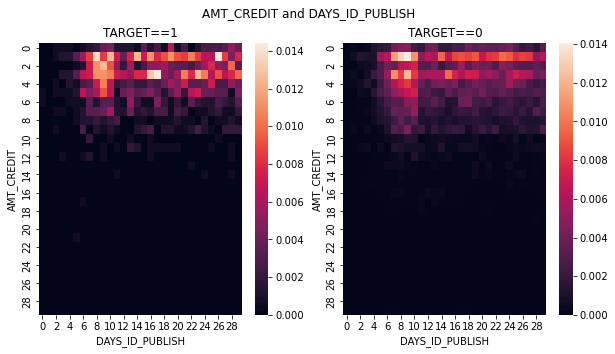

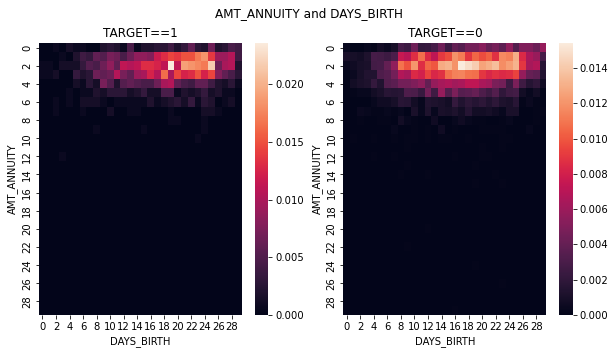

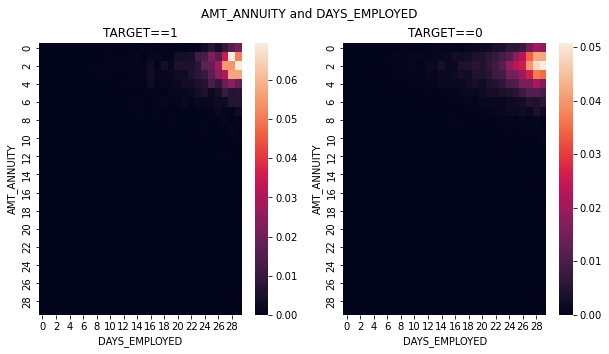

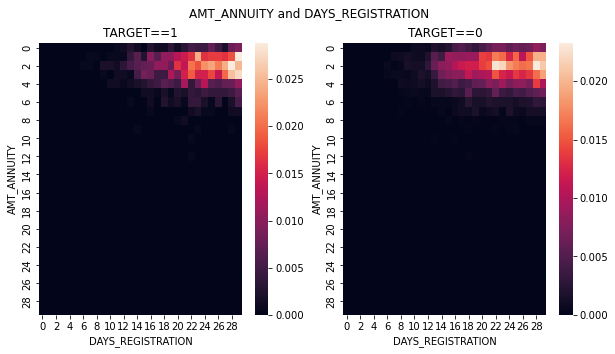

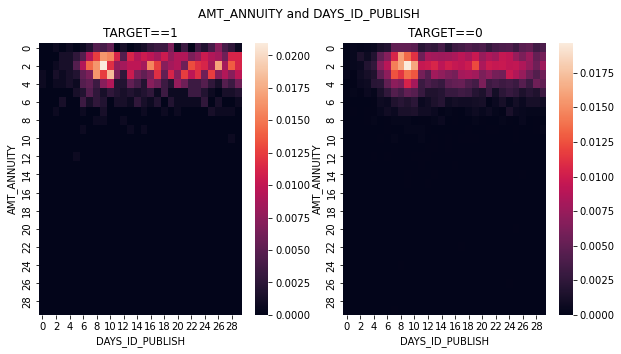

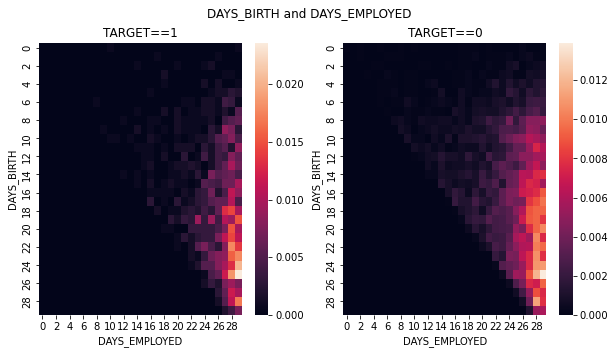

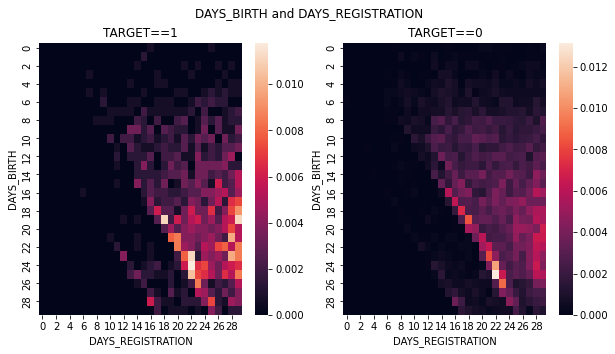

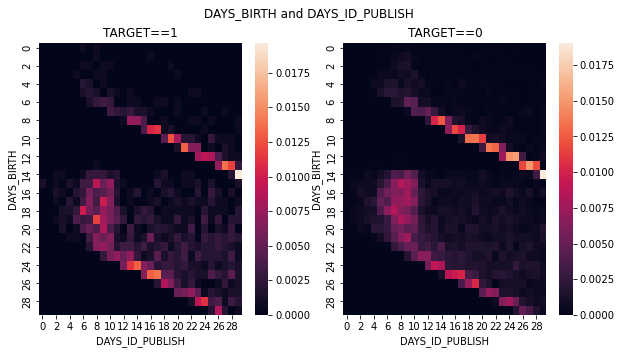

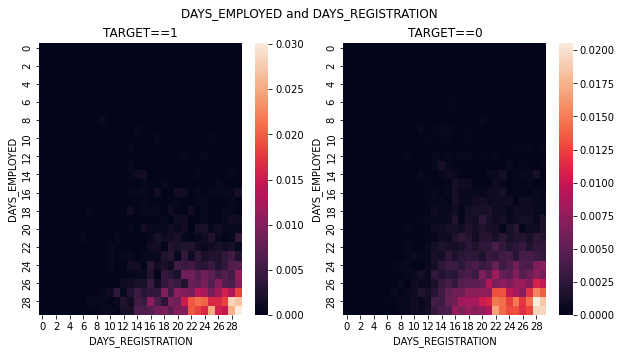

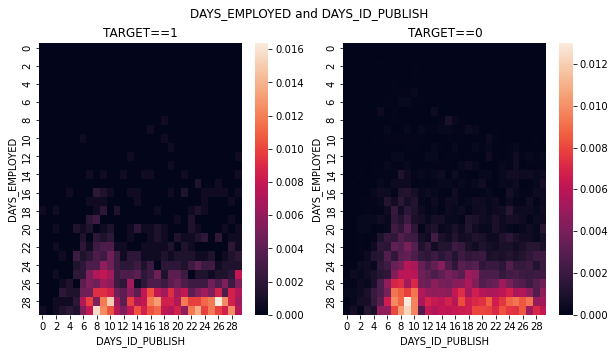

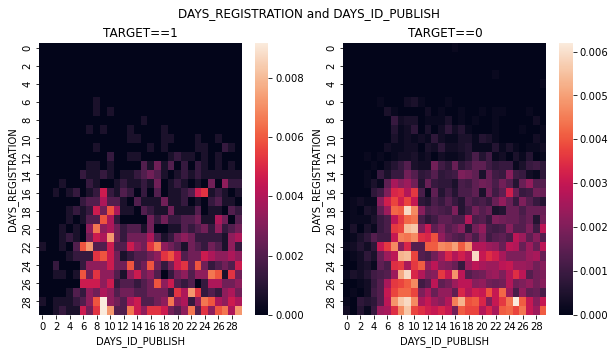

In [97]:
kolumny = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']
credit_num = credit_num.loc[(credit_num.AMT_INCOME_TOTAL < 10**8) & (credit_num.DAYS_EMPLOYED<=0)]
suma_NT = credit_num.loc[credit_num.TARGET==0].shape[0]
suma_T = credit_num.loc[credit_num.TARGET==1].shape[0]

for i,col_1 in enumerate(kolumny):
    for j,col_2 in enumerate(kolumny): 
        if (i>=j):
            continue   
        df = pd.DataFrame({col_1: pd.cut(credit_num[col_1],bins=30,labels=range(0,30)),\
                            col_2: pd.cut(credit_num[col_2],bins=30,labels=range(0,30)),\
                            'TARGET': credit_num.TARGET})
        df1 = df.loc[df.TARGET==1]
        df1 = df1.groupby([col_1,col_2]).value_counts().reset_index(name='suma').pivot(index=col_1,columns=col_2,values='suma').sort_index()/suma_T

        df2 = df.loc[df.TARGET==0]
        df2 = df2.groupby([col_1,col_2]).value_counts().reset_index(name='suma').pivot(index=col_1,columns=col_2,values='suma').sort_index()/suma_NT

        figure, axes = plt.subplots(1, 2, sharex=True,
                                    figsize=(10, 5))

        figure.suptitle(col_1 + " and " + col_2)
        sns.heatmap((df1),ax=axes[0],vmin=0)
        axes[0].set_title('TARGET==1')
        sns.heatmap((df2),ax=axes[1],vmin=0)
        axes[1].set_title('TARGET==0')


Po podziale na kubełki i umieszczenie tam recordów , kolor opisuje stosunek ilości recordów o TARGET==1 do wszyskich recordów ,które wylądowały w danym kubełku

0.1874539651362632


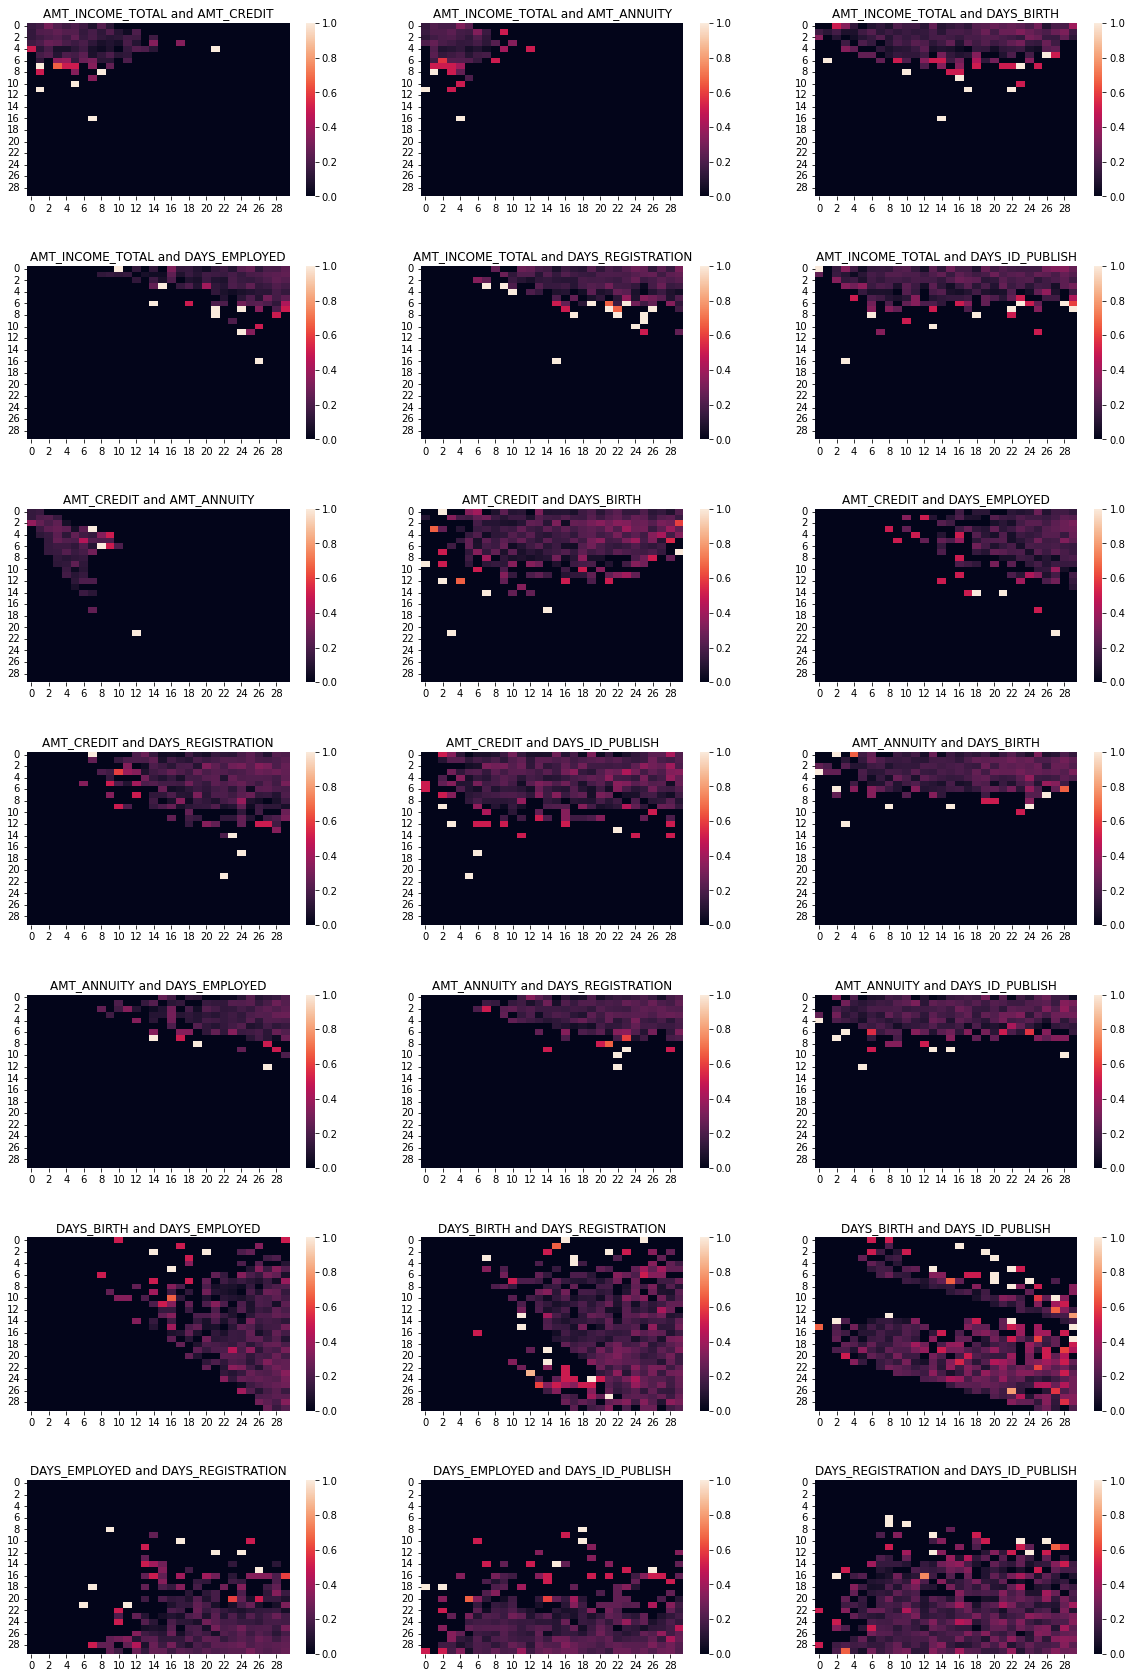

In [37]:
print(credit_heat_T2["count"].sum()/(credit_heat_NT2["count"].sum()+credit_heat_T2["count"].sum()))


n = 0
figure,axs = plt.subplots(7,3,figsize = (20,30))
figure.subplots_adjust(hspace = 0.4)
axs = axs.flatten()
for col_1_num,col_1 in enumerate(['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']):
    for col_2_num,col_2 in enumerate(['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']):
        if (col_1_num>=col_2_num): continue
        credit_heat_T2 = credit_heat_T[[col_1,col_2]].value_counts().reset_index(name = "count")
        credit_heat_NT2 = credit_heat_NT[[col_1,col_2]].value_counts().reset_index(name = "count")

        matrix_heat_T = np.zeros([30,30])
        matrix_heat_NT = np.zeros([30,30])
        matrix_heat_FINAL = np.zeros([30,30])

        for i in range(credit_heat_T2.shape[0]):
            matrix_heat_T[credit_heat_T2[col_1][i]-1,credit_heat_T2[col_2][i]-1] = credit_heat_T2["count"][i]
        for i in range(credit_heat_NT2.shape[0]):
            matrix_heat_NT[credit_heat_NT2[col_1][i]-1,credit_heat_NT2[col_2][i]-1] = credit_heat_NT2["count"][i]

        matrix_heat_ALL = matrix_heat_NT + matrix_heat_T

        for i in range(len(matrix_heat_ALL)):
            for j in range(len(matrix_heat_ALL)):
                if (matrix_heat_ALL[i,j]==0):
                    matrix_heat_FINAL[i,j] = -0.1
                else:
                    matrix_heat_FINAL[i,j] = matrix_heat_T[i,j]/matrix_heat_ALL[i,j]
                
        sns.heatmap(matrix_heat_FINAL,ax = axs[n],vmin=0,vmax=1)
        axs[n].set_title(col_1 + " and " + col_2)
        n+=1


To samo co powyzej, ale z pomocą walidatorów uzyskaliśmy czytelniejsza postac

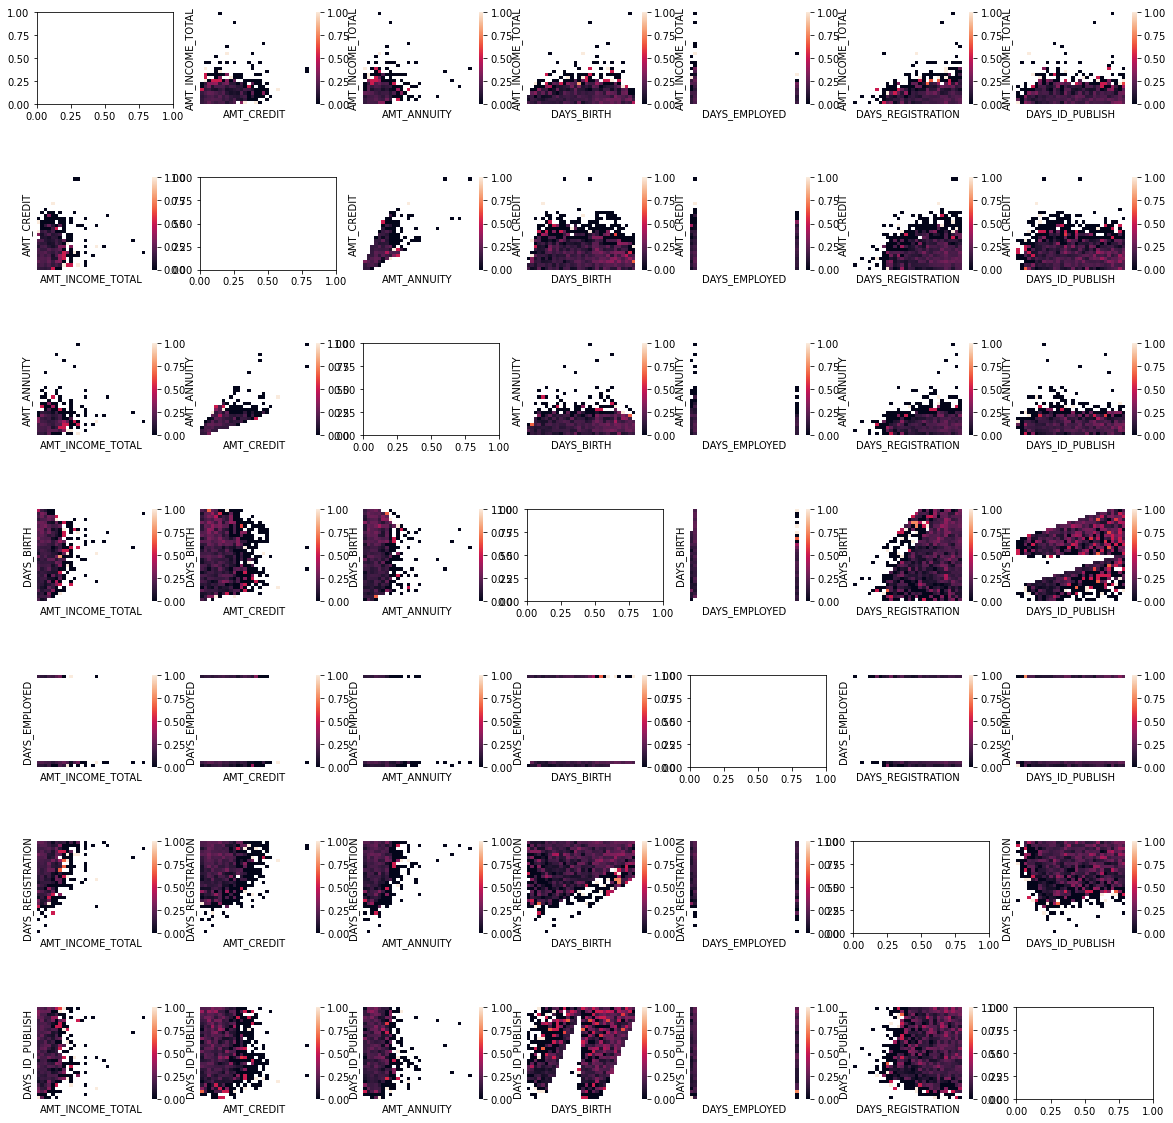

In [55]:
credit_num = credit_num.loc[credit_num.AMT_INCOME_TOTAL < 10**8]
kolumny = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']
figure,axes = plt.subplots(7,7,figsize = (20,20))
figure.subplots_adjust(hspace = 0.8)

for i,col_1 in enumerate(kolumny):
    for j,col_2 in enumerate(kolumny):
        if (i==j): continue
        df = pd.DataFrame({col_1: pd.cut(credit_num[col_1],30),\
                        col_2: pd.cut(credit_num[col_2],30),\
                        'TARGET': credit_num.TARGET})
        df = df.groupby([col_1, col_2]).mean().reset_index().pivot(index=col_1,columns=col_2,values='TARGET').sort_index(ascending=False)
        fig = sns.heatmap(data=df,vmin=0,vmax=1,ax = axes[i][j])
        fig.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

# Potencjalne transformacje danych
- przemiany log ,norm
- grupowanie zmienntych kategorycznych (wiecej niz 5 dzieci do tej samej kategorii, gdyz zbyt malo przypadkow ludzi z wieloma dziacmi)
- badanie zarowkow w zaleznosci od REGION_RATING_CLIENT

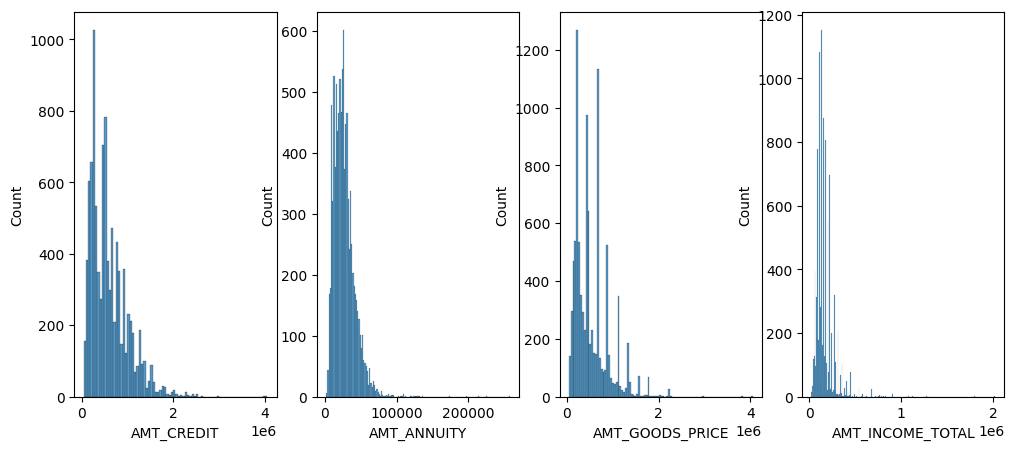

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(12, 5))
sns.histplot(data = credit.AMT_CREDIT,ax=axes[0])
sns.histplot(data = credit.AMT_ANNUITY,ax=axes[1])
sns.histplot(data = credit.AMT_GOODS_PRICE,ax=axes[2])
sns.histplot(data = credit[credit.AMT_INCOME_TOTAL!= credit.AMT_INCOME_TOTAL.max()].AMT_INCOME_TOTAL,ax=axes[3])

plt.show()

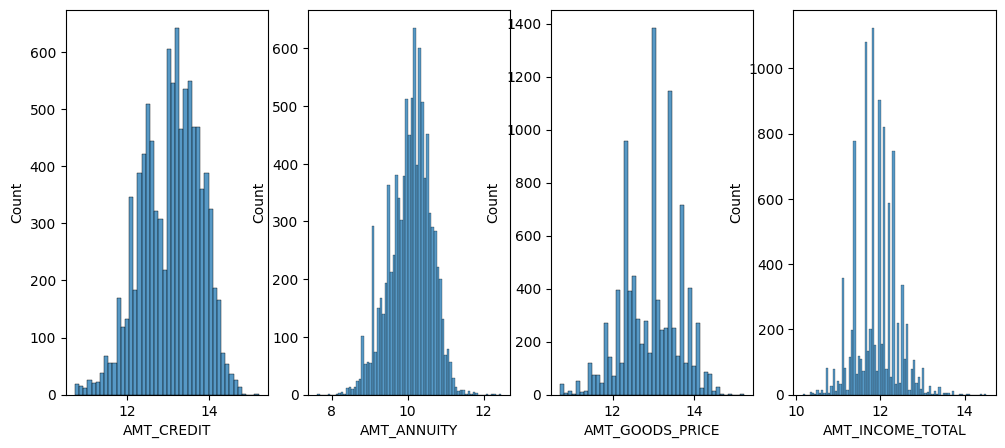

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(12, 5))
sns.histplot(data = np.log1p(credit.AMT_CREDIT),ax=axes[0])
sns.histplot(data = np.log1p(credit.AMT_ANNUITY),ax=axes[1])
sns.histplot(data = np.log1p(credit.AMT_GOODS_PRICE),ax=axes[2])
sns.histplot(data = np.log1p(credit[credit.AMT_INCOME_TOTAL!= credit.AMT_INCOME_TOTAL.max()].AMT_INCOME_TOTAL),ax=axes[3])
plt.show()

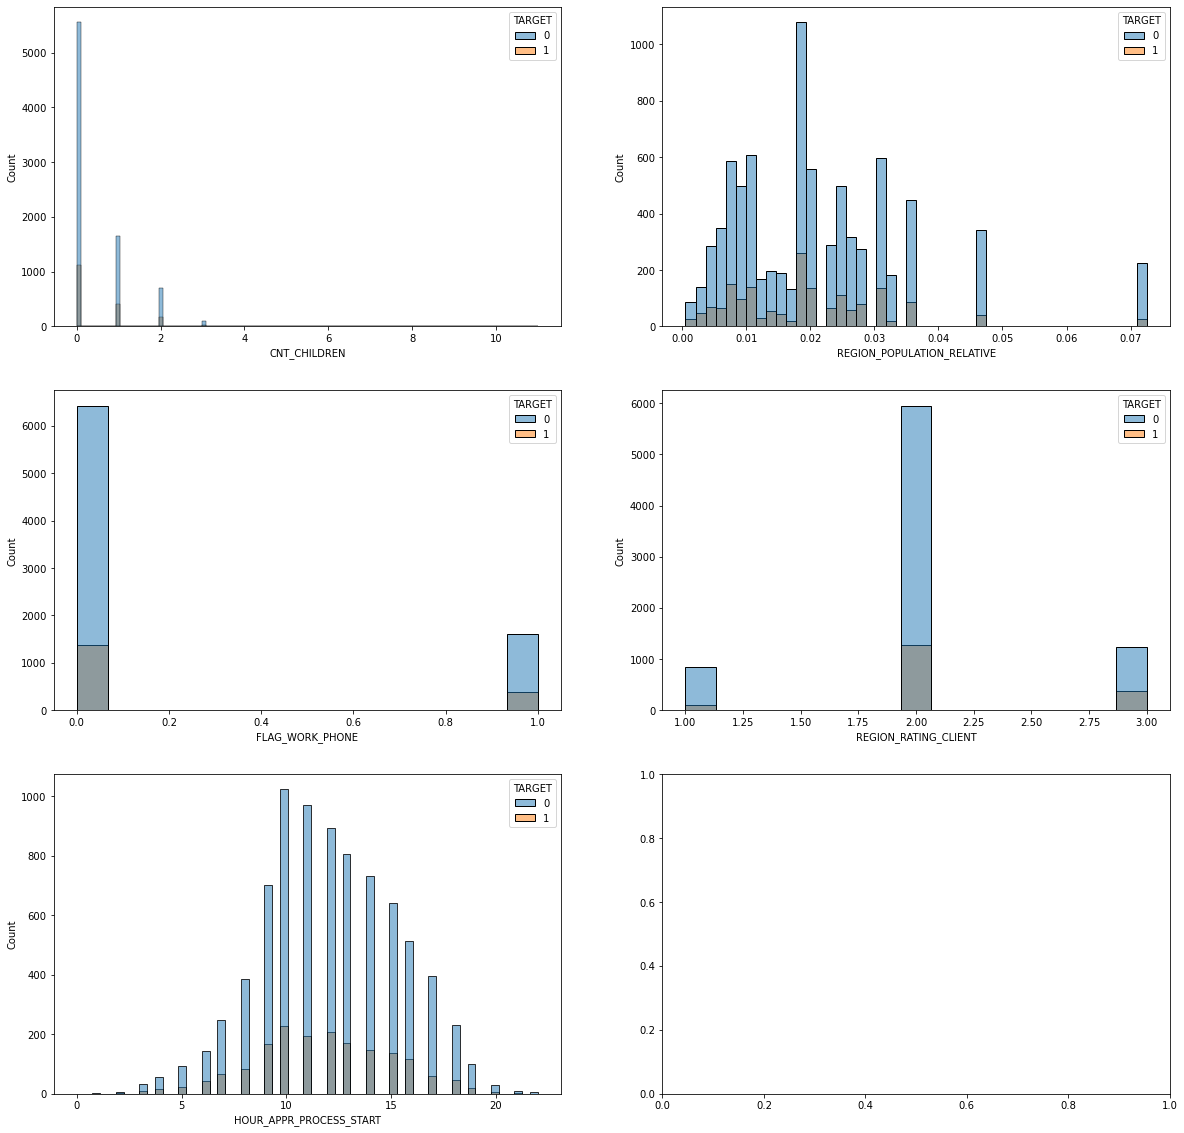

In [5]:
fig,axs = plt.subplots(3,2,figsize=(20,20))
axs = axs.flatten()
for i,j in enumerate(['CNT_CHILDREN','REGION_POPULATION_RELATIVE','FLAG_WORK_PHONE','REGION_RATING_CLIENT','HOUR_APPR_PROCESS_START']):
    sns.histplot(data=credit,x=j,hue='TARGET',ax = axs[i])

AMT_INCOME_TOTAL
TARGET REGION_RATING_CLIENT                  
0      1                        245116.347791
       2                        161456.285613
       3                        155484.690938
1      1                        235579.560811
       2                        159727.813022
       3                        149677.237030

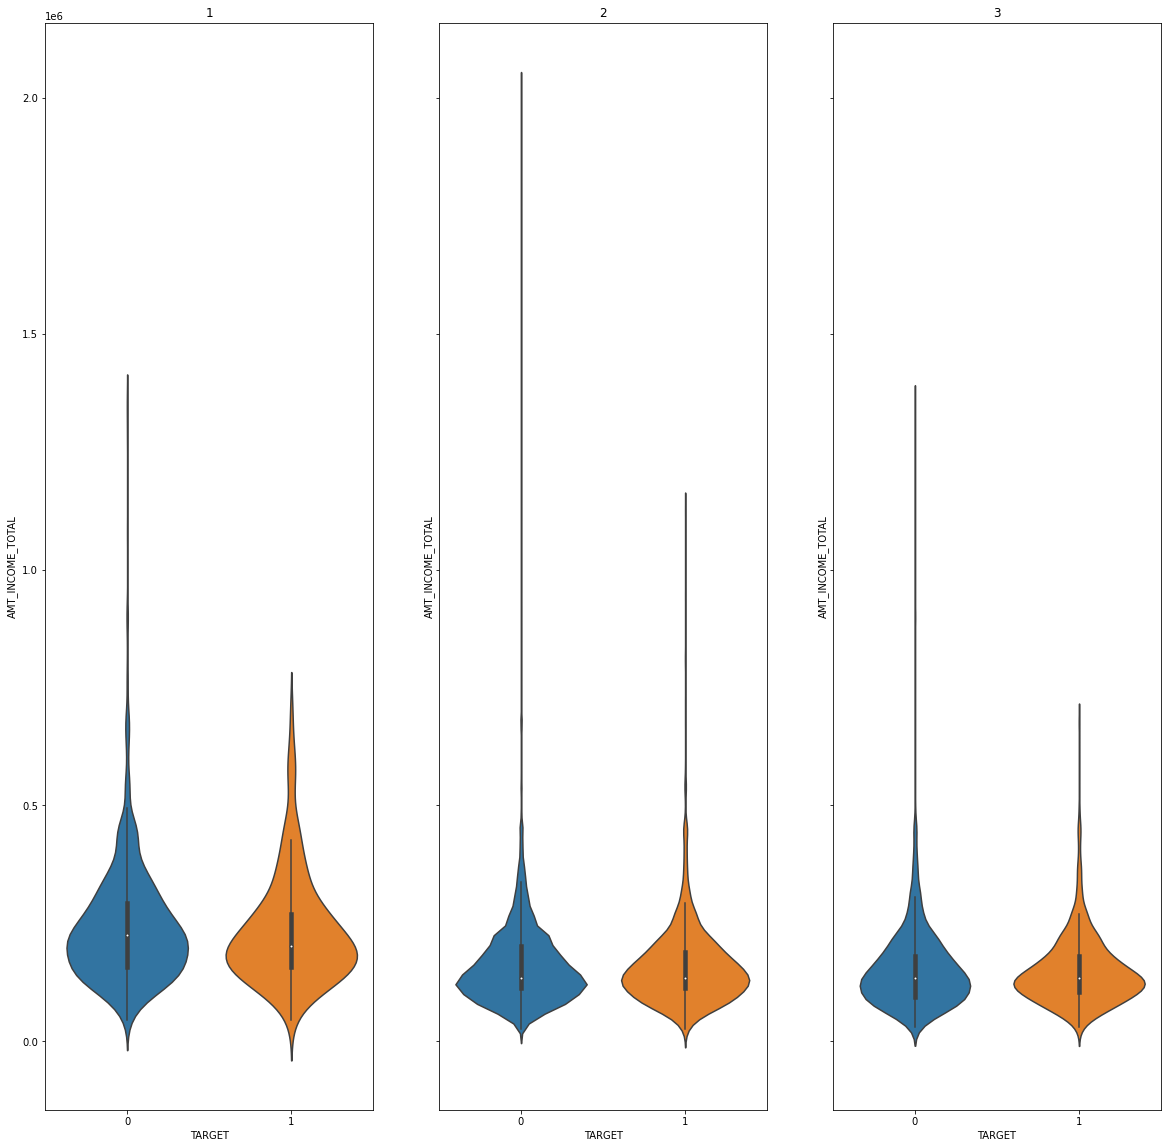

In [30]:
X_PRO = X_PRO.loc[X_PRO.AMT_INCOME_TOTAL<10**8]
fig,axs = plt.subplots(1,3,figsize=(20,20),sharey=True)
axs = axs.flatten()
for i in range(1,4):
    sns.violinplot(data=X_PRO.loc[X_PRO.REGION_RATING_CLIENT==i],x='TARGET',y='AMT_INCOME_TOTAL',ax=axs[i-1])
    axs[i-1].set_title(f'{i}')
X_PRO[['AMT_INCOME_TOTAL','TARGET','REGION_RATING_CLIENT']].groupby(['TARGET','REGION_RATING_CLIENT']).mean()

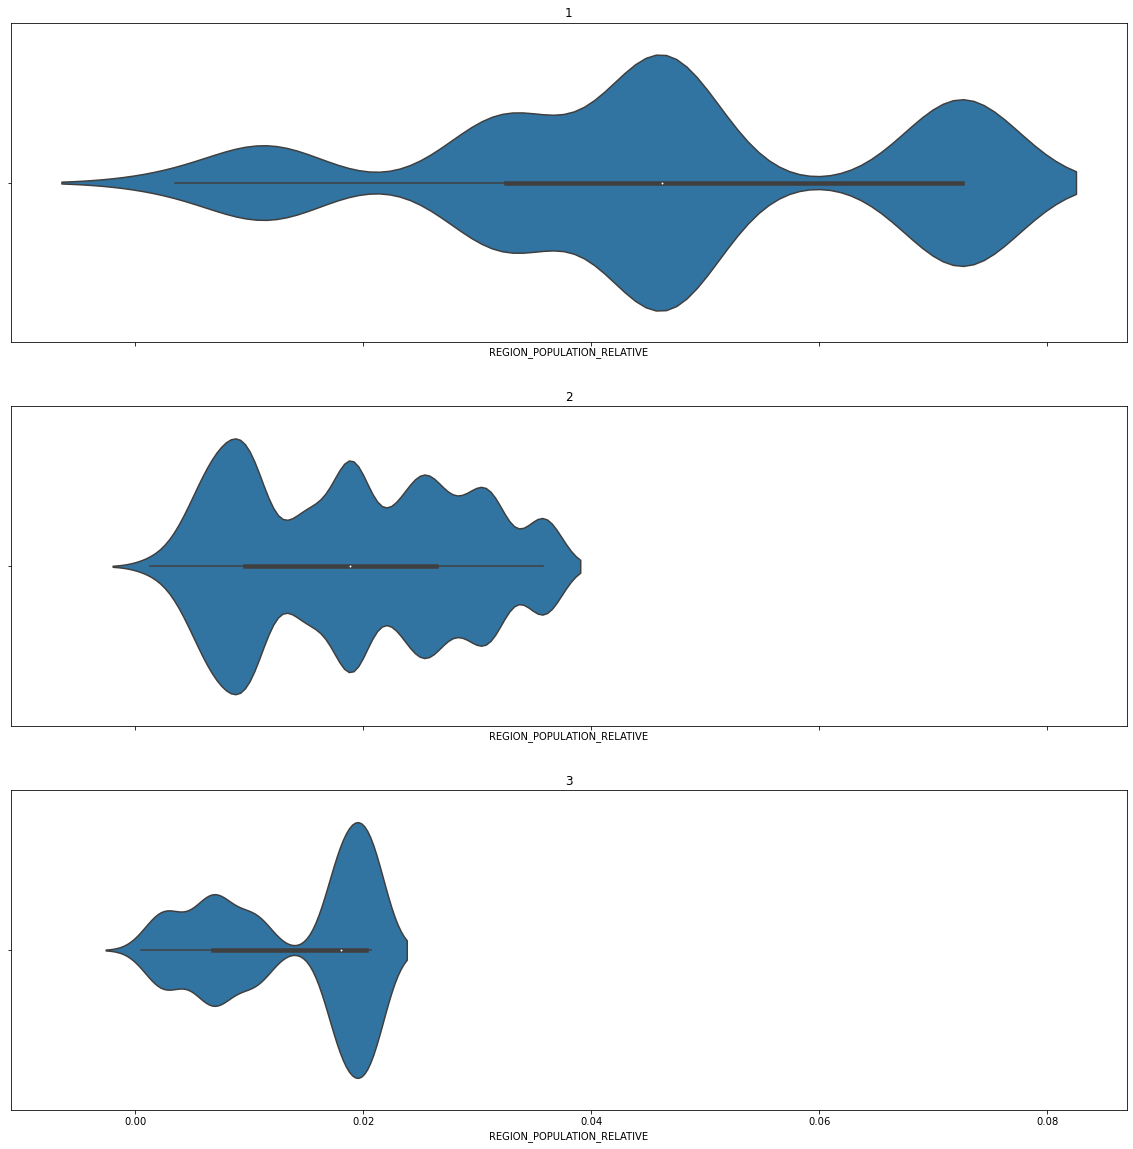

In [27]:
fig,axs = plt.subplots(3,1,figsize=(20,20),sharex=True)
axs = axs.flatten()
for i in range(1,4):
    sns.violinplot(data=credit.loc[credit.REGION_RATING_CLIENT==i],x='REGION_POPULATION_RELATIVE',ax=axs[i-1])
    axs[i-1].set_title(f'{i}')

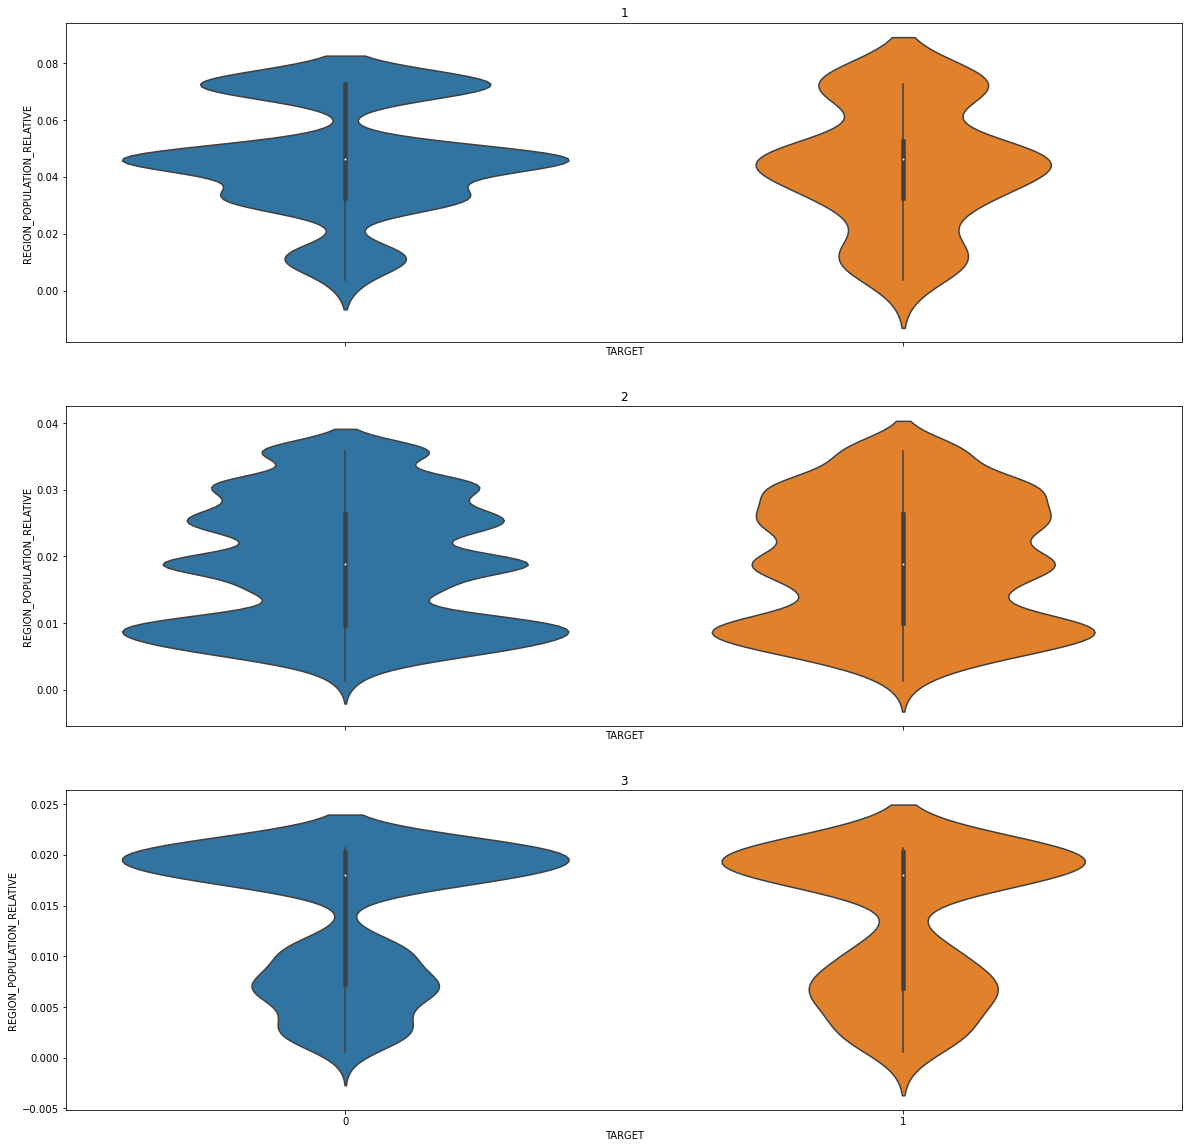

In [16]:
fig,axs = plt.subplots(3,1,figsize=(20,20),sharex=True)
axs = axs.flatten()
for i in range(1,4):
    sns.violinplot(data=credit.loc[credit.REGION_RATING_CLIENT==i],x='TARGET',y='REGION_POPULATION_RELATIVE',ax=axs[i-1])
    axs[i-1].set_title(f'{i}')

In [20]:
X_PRO[['CNT_CHILDREN','TARGET']].value_counts().sort_index()

CNT_CHILDREN  TARGET
0             0         7980
              1         1637
1             0         2342
              1          578
2             0         1005
              1          237
3             0          148
              1           40
4             0           13
              1            9
5             0            3
              1            2
6             0            3
8             0            1
9             1            1
11            1            1
dtype: int64

<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='Count'>

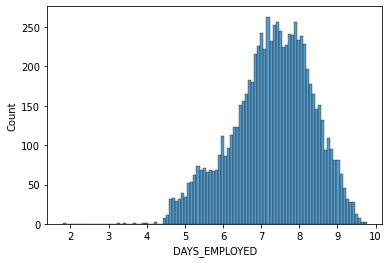

In [13]:
sns.histplot(data=np.log1p(-credit.loc[credit.DAYS_EMPLOYED<0].DAYS_EMPLOYED),bins=100)